In [1]:
#Loading necessary libraries for the project at hand
import warnings
import pandas as pd
import gradio as gr 
import numpy as np
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import pylab
import scipy.stats as stats
import seaborn as sns 
from pandasql import sqldf #SQL for data wrangling
from xgboost import (XGBClassifier, plot_importance)
from time import time
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [20]:
#Read dataset
df_fwa = pd.read_csv("/Users/olajideajayi/OneDrive - Microsoft/Desktop/WIP/FWA/fwa_ed_em_codes.csv")
df_fwa.head()

,procedures_DATE,procedures_PATIENT,procedures_ENCOUNTER,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST,procedures_REASONCODE,procedures_REASONDESCRIPTION,encounters_ORGANIZATION,encounters_PROVIDER,encounters_PAYER,providers_NAME,organizations_NAME,payers_NAME,patients_NAME
0,2011-04-30T00:26:23Z,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,6aa37300-d1b4-48e7-a2f8-5e0f70f48f38,169553002.0,Insertion of subcutaneous contraceptive,14896.56,10509.0,Headache,b0e04623-b02c-3f8b-92ea-943fc4db60da,58b66cc1-2b86-377f-ad77-ad8164388e50,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,Veda284 Pfeffer420,LOWELL GENERAL HOSPITAL,NO_INSURANCE,Mariana775 Rutherford999
1,2010-07-27T12:58:08Z,10339b10-3cd1-4ac3-ac13-ec26728cb592,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,99285.0,Emergency department visit for the evaluation ...,990.00,10611.0,Chest Pain,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,Dwayne786 Reilly981,WESTERN MASS PHYSICIAN ASSOCIATES INC,Humana,Jayson808 Fadel536
2,2010-11-20T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,7ff86631-0378-4bfc-92ce-1edd697eb18e,99285.0,Emergency department visit for the evaluation ...,990.00,10509.0,Headache,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
3,2011-02-07T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,b8f76eba-7795-4dcd-a544-f27ac2ef3d46,117015009.0,Throat culture (procedure),2070.44,195662009.0,Acute viral pharyngitis (disorder),27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97
4,2011-04-19T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,640837d9-845a-433c-9fad-47426664a69d,117015009.0,Throat culture (procedure),2479.39,195662009.0,Acute viral pharyngitis (disorder),27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97


In [21]:
#Data structure
df_fwa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34981 entries, 0 to 34980
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   procedures_DATE               34981 non-null  object 
 1   procedures_PATIENT            34981 non-null  object 
 2   procedures_ENCOUNTER          34981 non-null  object 
 3   procedures_CODE               34981 non-null  float64
 4   procedures_DESCRIPTION        34981 non-null  object 
 5   procedures_BASE_COST          34981 non-null  float64
 6   procedures_REASONCODE         34981 non-null  float64
 7   procedures_REASONDESCRIPTION  34981 non-null  object 
 8   encounters_ORGANIZATION       34981 non-null  object 
 9   encounters_PROVIDER           34981 non-null  object 
 10  encounters_PAYER              34981 non-null  object 
 11  providers_NAME                34981 non-null  object 
 12  organizations_NAME            34981 non-null  object 
 13  p

In [23]:
#Number of records
len(df_fwa.index)

34981

In [24]:
df_fwa.head()

,procedures_DATE,procedures_PATIENT,procedures_ENCOUNTER,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST,procedures_REASONCODE,procedures_REASONDESCRIPTION,encounters_ORGANIZATION,encounters_PROVIDER,encounters_PAYER,providers_NAME,organizations_NAME,payers_NAME,patients_NAME
0,2011-04-30T00:26:23Z,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,6aa37300-d1b4-48e7-a2f8-5e0f70f48f38,169553002.0,Insertion of subcutaneous contraceptive,14896.56,10509.0,Headache,b0e04623-b02c-3f8b-92ea-943fc4db60da,58b66cc1-2b86-377f-ad77-ad8164388e50,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,Veda284 Pfeffer420,LOWELL GENERAL HOSPITAL,NO_INSURANCE,Mariana775 Rutherford999
1,2010-07-27T12:58:08Z,10339b10-3cd1-4ac3-ac13-ec26728cb592,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,99285.0,Emergency department visit for the evaluation ...,990.00,10611.0,Chest Pain,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,Dwayne786 Reilly981,WESTERN MASS PHYSICIAN ASSOCIATES INC,Humana,Jayson808 Fadel536
2,2010-11-20T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,7ff86631-0378-4bfc-92ce-1edd697eb18e,99285.0,Emergency department visit for the evaluation ...,990.00,10509.0,Headache,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
3,2011-02-07T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,b8f76eba-7795-4dcd-a544-f27ac2ef3d46,117015009.0,Throat culture (procedure),2070.44,195662009.0,Acute viral pharyngitis (disorder),27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97
4,2011-04-19T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,640837d9-845a-433c-9fad-47426664a69d,117015009.0,Throat culture (procedure),2479.39,195662009.0,Acute viral pharyngitis (disorder),27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97


In [106]:
#Select Specific Data Elements for Emergency Department (ED) Evaluation and Management (E/M) codes
a="""select x.* from df_fwa x 
where x.procedures_CODE in (99281.0,99282.0,99283.0,99284.0,99285.0);"""
pysqldf = lambda a: sqldf(a, globals())
fwa_ed_em_codes = pysqldf(a)

In [107]:
fwa_ed_em_codes.head()

,procedures_DATE,procedures_PATIENT,procedures_ENCOUNTER,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST,procedures_REASONCODE,procedures_REASONDESCRIPTION,encounters_ORGANIZATION,encounters_PROVIDER,encounters_PAYER,providers_NAME,organizations_NAME,payers_NAME,patients_NAME
0,2010-07-27T12:58:08Z,10339b10-3cd1-4ac3-ac13-ec26728cb592,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,99285.0,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,Dwayne786 Reilly981,WESTERN MASS PHYSICIAN ASSOCIATES INC,Humana,Jayson808 Fadel536
1,2010-11-20T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,7ff86631-0378-4bfc-92ce-1edd697eb18e,99285.0,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
2,2011-11-26T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,1923c698-accd-4d70-ba09-e1938f6e96d1,99285.0,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
3,2012-01-07T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,16300c56-a035-4126-a656-68c093da6dfc,99285.0,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97
4,2015-01-26T17:45:28Z,034e9e3b-2def-4559-bb2a-7850888ae060,e3639187-450a-4aa9-9fc9-3ea3cafa672b,99285.0,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,772ee193-bb9f-30eb-9939-21e86c8e4da5,6f1d59a7-a5bd-3cf9-9671-5bad2f351c28,6e2f1a2d-27bd-3701-8d08-dae202c58632,Ellan282 Krajcik437,PCP20565,Blue Cross Blue Shield,Milo271 Feil794


In [108]:
#Number of records
len(fwa_ed_em_codes.index)

15928

In [150]:
#Date Range
fwa_ed_em_codes['procedures_DATE'] = pd.to_datetime(fwa_ed_em_codes['procedures_DATE'])

In [159]:
min(fwa_ed_em_codes['procedures_DATE'])

Timestamp('1916-05-05 23:35:03+0000', tz='UTC')

In [160]:
max(fwa_ed_em_codes['procedures_DATE'])

Timestamp('2020-04-28 18:58:37+0000', tz='UTC')

In [161]:
(max(fwa_ed_em_codes['procedures_DATE'])-min(fwa_ed_em_codes['procedures_DATE']))

Timedelta('37978 days 19:23:34')

In [152]:
fwa_ed_em_codes.head()

,procedures_DATE,procedures_PATIENT,procedures_ENCOUNTER,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST,procedures_REASONCODE,procedures_REASONDESCRIPTION,encounters_ORGANIZATION,encounters_PROVIDER,encounters_PAYER,providers_NAME,organizations_NAME,payers_NAME,patients_NAME
0,2010-07-27 12:58:08+00:00,10339b10-3cd1-4ac3-ac13-ec26728cb592,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,Dwayne786 Reilly981,WESTERN MASS PHYSICIAN ASSOCIATES INC,Humana,Jayson808 Fadel536
1,2010-11-20 03:04:34+00:00,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,7ff86631-0378-4bfc-92ce-1edd697eb18e,99285,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
2,2011-11-26 03:04:34+00:00,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,1923c698-accd-4d70-ba09-e1938f6e96d1,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
3,2012-01-07 03:04:34+00:00,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,16300c56-a035-4126-a656-68c093da6dfc,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97
4,2015-01-26 17:45:28+00:00,034e9e3b-2def-4559-bb2a-7850888ae060,e3639187-450a-4aa9-9fc9-3ea3cafa672b,99285,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,772ee193-bb9f-30eb-9939-21e86c8e4da5,6f1d59a7-a5bd-3cf9-9671-5bad2f351c28,6e2f1a2d-27bd-3701-8d08-dae202c58632,Ellan282 Krajcik437,PCP20565,Blue Cross Blue Shield,Milo271 Feil794


In [109]:
#Data Summary
fwa_ed_em_codes.describe()

,procedures_CODE,procedures_BASE_COST,procedures_REASONCODE
count,15928.000000,15928.000000,1.592800e+04
mean,99283.562155,663.254332,2.476499e+07
std,1.362719,343.158066,3.451712e+07
min,99281.000000,125.000000,1.050900e+04
25%,99282.000000,220.000000,1.050900e+04
50%,99284.000000,890.000000,1.061100e+04
75%,99285.000000,990.000000,7.289200e+07
max,99285.000000,990.000000,7.289200e+07


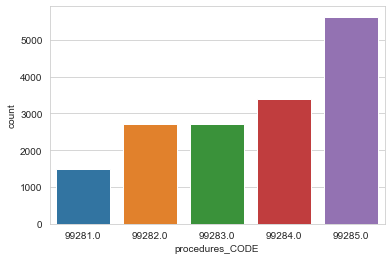

In [110]:
#Graph Distribution - fwa_ed_em_codes
sns.countplot(fwa_ed_em_codes['procedures_CODE'])
plt.show()
#Model fairness - Responsible AI to be revisited later

In [111]:
#Convert procedures_CODE to string
fwa_ed_em_codes['procedures_CODE'] = fwa_ed_em_codes['procedures_CODE'].astype(str).apply(lambda x: x.replace('.0',''))

In [112]:
fwa_ed_em_codes.head()

,procedures_DATE,procedures_PATIENT,procedures_ENCOUNTER,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST,procedures_REASONCODE,procedures_REASONDESCRIPTION,encounters_ORGANIZATION,encounters_PROVIDER,encounters_PAYER,providers_NAME,organizations_NAME,payers_NAME,patients_NAME
0,2010-07-27T12:58:08Z,10339b10-3cd1-4ac3-ac13-ec26728cb592,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,Dwayne786 Reilly981,WESTERN MASS PHYSICIAN ASSOCIATES INC,Humana,Jayson808 Fadel536
1,2010-11-20T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,7ff86631-0378-4bfc-92ce-1edd697eb18e,99285,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
2,2011-11-26T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,1923c698-accd-4d70-ba09-e1938f6e96d1,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,58b8fe10-e28a-313e-93b0-486d1246c364,e755f853-29a9-3772-b889-589c1c172021,047f6ec3-6215-35eb-9608-f9dda363a44c,Buster609 Lemke654,PCP346663,Cigna Health,Gregorio366 Auer97
3,2012-01-07T03:04:34Z,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,16300c56-a035-4126-a656-68c093da6dfc,99285,Emergency department visit for the evaluation ...,990.0,10611.0,Chest Pain,27379046-608b-32f0-9df7-8c833cf5d11d,12b801f8-7b4e-369e-80b9-4205c25aab0f,047f6ec3-6215-35eb-9608-f9dda363a44c,Kasi212 Hickle134,BRIGHAM AND WOMEN'S HOSPITAL,Cigna Health,Gregorio366 Auer97
4,2015-01-26T17:45:28Z,034e9e3b-2def-4559-bb2a-7850888ae060,e3639187-450a-4aa9-9fc9-3ea3cafa672b,99285,Emergency department visit for the evaluation ...,990.0,10509.0,Headache,772ee193-bb9f-30eb-9939-21e86c8e4da5,6f1d59a7-a5bd-3cf9-9671-5bad2f351c28,6e2f1a2d-27bd-3701-8d08-dae202c58632,Ellan282 Krajcik437,PCP20565,Blue Cross Blue Shield,Milo271 Feil794


In [134]:
#Pivot using SQL - Units and Cost
b="""select distinct x.organizations_NAME,x.providers_NAME,x.payers_NAME,x.procedures_REASONDESCRIPTION,
    sum(case when procedures_CODE='99281' then 1 else 0 end) as 'U_99281',
    sum(case when procedures_CODE='99282' then 1 else 0 end) as 'U_99282',
    sum(case when procedures_CODE='99283' then 1 else 0 end) as 'U_99283',
    sum(case when procedures_CODE='99284' then 1 else 0 end) as 'U_99284',
    sum(case when procedures_CODE='99285' then 1 else 0 end) as 'U_99285',
    sum(case when procedures_CODE='99281' then procedures_BASE_COST else 0 end) as 'Cost_99281',
    sum(case when procedures_CODE='99282' then procedures_BASE_COST else 0 end) as 'Cost_99282',
    sum(case when procedures_CODE='99283' then procedures_BASE_COST else 0 end) as 'Cost_99283',
    sum(case when procedures_CODE='99284' then procedures_BASE_COST else 0 end) as 'Cost_99284',
    sum(case when procedures_CODE='99285' then procedures_BASE_COST else 0 end) as 'Cost_99285'
from fwa_ed_em_codes x 
group by organizations_NAME,providers_NAME,payers_NAME,procedures_REASONDESCRIPTION
;"""
pysqldf = lambda b: sqldf(b, globals())
pivot_table = pysqldf(b)

In [135]:
pivot_table.head()

,organizations_NAME,providers_NAME,payers_NAME,procedures_REASONDESCRIPTION,U_99281,U_99282,U_99283,U_99284,U_99285,Cost_99281,Cost_99282,Cost_99283,Cost_99284,Cost_99285
0,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Anthem,Chest Pain,0,0,0,0,3,0.0,0.0,0.0,0.0,2970.0
1,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Anthem,Headache,0,0,0,0,3,0.0,0.0,0.0,0.0,2970.0
2,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Blue Cross Blue Shield,Chest Pain,0,0,0,0,2,0.0,0.0,0.0,0.0,1980.0
3,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Blue Cross Blue Shield,Headache,0,0,0,0,3,0.0,0.0,0.0,0.0,2970.0
4,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Cigna Health,Headache,0,0,0,0,1,0.0,0.0,0.0,0.0,990.0


In [136]:
#Aggregate to get units total
c="""select distinct x.*, (U_99281+U_99282+U_99283+U_99284+U_99285) as Total
from pivot_table x 
group by organizations_NAME,providers_NAME,payers_NAME,procedures_REASONDESCRIPTION,'U_99281','U_99282','U_99283','U_99284','U_99285',
'Cost_99281','Cost_99282','Cost_99283','Cost_99284','Cost_99285'
;"""
pysqldf = lambda c: sqldf(c, globals())
pivot_table_tot = pysqldf(c)

In [147]:
#Ratios
d="""select distinct x.*, (U_99281*1.0/Total) as Ratio_99281,(U_99282*1.0/Total) as Ratio_99282,(U_99283*1.0/Total) as Ratio_99283,(U_99284*1.0/Total) as Ratio_99284,(U_99285*1.0/Total) as Ratio_99285
from pivot_table_tot x 
group by organizations_NAME,providers_NAME,payers_NAME,procedures_REASONDESCRIPTION,'U_99281','U_99282','U_99283','U_99284','U_99285',
'Cost_99281','Cost_99282','Cost_99283','Cost_99284','Cost_99285',Total
;"""
pysqldf = lambda d: sqldf(d, globals())
pivot_table_tot_ratio = pysqldf(d)

In [162]:
#Flag Suspecious FWA using Ratios distribution
e="""select x.*, 
case when (Ratio_99284>=0.3 or Ratio_99285>=0.3) and Total>=100 then 1 else 0 end as Flag
from pivot_table_tot_ratio x 
;"""
pysqldf = lambda e: sqldf(e, globals())
pivot_table_tot_ratio_flag = pysqldf(e)

In [163]:
pivot_table_tot_ratio_flag.head()

,organizations_NAME,providers_NAME,payers_NAME,procedures_REASONDESCRIPTION,U_99281,U_99282,U_99283,U_99284,U_99285,Cost_99281,...,Cost_99283,Cost_99284,Cost_99285,Total,Ratio_99281,Ratio_99282,Ratio_99283,Ratio_99284,Ratio_99285,Flag
0,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Anthem,Chest Pain,0,0,0,0,3,0.0,...,0.0,0.0,2970.0,3,0.0,0.0,0.0,0.0,1.0,0
1,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Anthem,Headache,0,0,0,0,3,0.0,...,0.0,0.0,2970.0,3,0.0,0.0,0.0,0.0,1.0,0
2,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Blue Cross Blue Shield,Chest Pain,0,0,0,0,2,0.0,...,0.0,0.0,1980.0,2,0.0,0.0,0.0,0.0,1.0,0
3,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Blue Cross Blue Shield,Headache,0,0,0,0,3,0.0,...,0.0,0.0,2970.0,3,0.0,0.0,0.0,0.0,1.0,0
4,A PLUS CHIROPRACTIC MANAGEMENT INC,Ali918 Erdman779,Cigna Health,Headache,0,0,0,0,1,0.0,...,0.0,0.0,990.0,1,0.0,0.0,0.0,0.0,1.0,0


In [164]:
pivot_table_tot_ratio_flag.to_csv('/Users/olajideajayi/OneDrive - Microsoft/Desktop/WIP/FWA/pivot_table_tot_ratio_flag.csv',index=False)